In [1]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from src.caseDataset import CaseDataset

## Check GPU Availability

In [4]:
# Check GPU status:
print('PyTorch version:',t.__version__)
useGPU = t.cuda.is_available()
if(useGPU):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    dev = t.cuda.current_device()
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.8.2
Device  0 : NVIDIA GeForce GTX 1050
Current: Device  0


## Load Data

In [5]:
# load data
txtSubname = "contiAge001"
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
A, B, C, D = coef[0], coef[1], coef[2], coef[3]
totalData

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,-0.92,-1.0,1.0,115.0,-105.0,112.040010,-108.237789,-108.8,-138.8,-104.260130,-140.967104,-108.8,36.0,-110.884371,30.903047
1,-1.0,0.48,1.0,1.0,-105.0,115.0,-106.879361,116.286714,57.2,87.2,53.461226,90.748609,-34.0,87.2,-35.642870,82.665815
2,-1.0,0.04,1.0,-1.0,75.0,-85.0,74.052244,-84.644700,-22.0,8.0,-25.346215,11.366214,-22.0,15.6,-23.603358,12.001047
3,1.0,-0.88,-1.0,-1.0,-85.0,75.0,-82.993870,87.191321,54.0,24.0,44.554073,22.917291,-113.2,24.0,-105.024805,31.829598
4,-1.0,0.48,1.0,-1.0,75.0,-85.0,73.324002,-83.807528,-44.0,-14.0,-48.902361,-14.328907,-44.0,77.2,-42.046240,80.655396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,-1.00,-1.0,1.0,115.0,-105.0,118.519213,-109.426492,-120.0,-150.0,-119.067786,-147.635503,-120.0,40.0,-123.034190,34.374009
996,1.0,-0.76,-1.0,-1.0,-85.0,75.0,-85.577661,74.330939,48.0,18.0,46.021282,20.169814,-96.4,18.0,-97.628791,11.250763
997,-1.0,0.32,1.0,1.0,-105.0,115.0,-102.230083,114.539388,34.8,64.8,35.821692,61.666962,-26.0,64.8,-26.790577,63.975273
998,-1.0,0.08,1.0,1.0,-105.0,115.0,-105.411036,114.494782,1.2,31.2,-3.440703,32.867533,-14.0,31.2,-13.550583,24.036370


In [6]:
totalData.describe()

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
count,1000.0000,1.000000e+03,1000.0000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0000,-4.773959e-18,0.0000,0.0000,0.000000,0.000000,0.204553,-0.045644,-2.060574e-15,-4.263256e-16,0.137084,-0.133012,-48.290400,48.290400,-48.367955,48.397390
std,1.0005,5.949403e-01,1.0005,1.0005,96.354991,96.354991,96.171196,96.609462,5.906112e+01,6.953177e+01,58.996498,69.837219,33.782902,50.129875,34.053444,50.386645
min,-1.0000,-1.000000e+00,-1.0000,-1.0000,-105.000000,-105.000000,-121.145339,-121.631259,-1.500000e+02,-1.500000e+02,-150.369549,-155.780906,-130.000000,-120.000000,-138.811764,-122.679009
25%,-1.0000,-5.200000e-01,-1.0000,-1.0000,-90.000000,-90.000000,-94.613137,-95.574938,-4.740000e+01,-3.400000e+01,-47.280723,-34.666652,-64.000000,10.000000,-65.535146,10.169123
50%,0.0000,0.000000e+00,0.0000,0.0000,-5.000000,-5.000000,-2.069445,-5.074530,3.200000e+00,-4.000000e+00,3.931817,-5.200589,-46.000000,31.200000,-45.768336,32.049127
75%,1.0000,5.200000e-01,1.0000,1.0000,85.000000,85.000000,93.076622,96.225192,4.280000e+01,2.850000e+01,42.666312,28.430369,-26.000000,87.200000,-26.255625,86.188935
max,1.0000,1.000000e+00,1.0000,1.0000,115.000000,115.000000,126.355519,127.703335,1.600000e+02,1.600000e+02,165.016918,166.387912,160.000000,160.000000,165.416947,169.466546


In [7]:
trainData, testData = totalData, totalData#train_test_split(totalData, test_size=0.2)

caseType = 3
trainCaseData = CaseDataset(trainData, caseType=caseType)
testCaseData = CaseDataset(testData, caseType=caseType)
print("TrainCase Treat Rate: {}".format(np.mean(trainCaseData.T == 1)))
print("TestCase Treat Rate: {}".format(np.mean(testCaseData.T == 1)))

TrainCase Treat Rate: 0.5
TestCase Treat Rate: 0.5


In [8]:
iteration = 1
trainDataLoader = DataLoader(trainCaseData, batch_size=int(len(trainCaseData)/iteration), shuffle=True)
print("Batched Training Shape of")
for i, (batchFeature, batchTarget) in enumerate(trainDataLoader):
    print("No. {} | Feature: {} | Target: {}".format(i, batchFeature.shape, batchTarget.shape))
print("\n")
testDataLoader = DataLoader(testCaseData, batch_size=int(len(testCaseData)/iteration), shuffle=False)
testFeature, testTarget = next(iter(testDataLoader))
print("Test Shape of \nFeature: {} | Target: {}".format(testFeature.shape, testTarget.shape))

Batched Training Shape of
No. 0 | Feature: torch.Size([1000, 3]) | Target: torch.Size([1000])


Test Shape of 
Feature: torch.Size([1000, 3]) | Target: torch.Size([1000])


---

## Model Build Up

In [9]:
from src.neuralNetwork import *

In [10]:
model = NeuralNetwork()
loss_fn = t.nn.MSELoss()
learningRate = 1e-5
optimizer = t.optim.RMSprop(model.parameters())#, lr=learningRate)


model = model.to(dev)
loss_fn = loss_fn.to(dev)
if useGPU:
    print('---------- Turn Model/LossFunction into GPU ----------')
else:
    print('---------- Turn Model/LossFunction into CPU ----------')
print(model)

---------- Turn Model/LossFunction into GPU ----------
NeuralNetwork(
  (linearLayer): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [11]:
#del model

In [12]:
numEpochs = 1000

for epochIdx in range(numEpochs+1):
    loss = trainLoop(dataLoader=trainDataLoader, model=model, optimizer=optimizer, lossFn=loss_fn, dev=dev)
    if epochIdx % 250 == 0:
        print('-' * 20 + str(epochIdx) + '-' * 20)    
        print('Loss: {}'.format(loss))


print('=' * 10 + 'COMPLETE' + '=' * 10)

--------------------0--------------------
Loss: 3513.408203125
--------------------250--------------------
Loss: 38.08910369873047
--------------------500--------------------
Loss: 27.703262329101562
--------------------750--------------------
Loss: 25.937341690063477
--------------------1000--------------------
Loss: 25.149677276611328
==========COMPLETE==========


In [13]:
yTrainPred = evaluate(model, trainCaseData.feature, dev=dev)
yTrainPredCF = evaluate(model, trainCaseData.featureCF, dev=dev)

In [14]:
doDraw = True

In [15]:
import matplotlib.pyplot as plt 
import numpy as np 
def drawOutcomesVersusRandom(trainCaseData, yPred, yType, coefficients, title, yPredCF=None):
    uniqueOutcome, countUnique = np.unique(trainCaseData.data['yo'+yType], return_counts=True)
    A, B, C, D = coefficients[0], coefficients[1], coefficients[2], coefficients[3]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(len(uniqueOutcome)):
        # ========== Treated
        if np.sum([(trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('green')
                pc.set_edgecolor('green')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('green')
                vp.set_facecolor('green')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='green', fontsize=25, ha='center')

        # ========== Untreated
        elif np.sum([(trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('red')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('red')
                vp.set_facecolor('red')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='red', fontsize=25, ha='center')

    size = 70
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType], color='black', zorder=3)
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType+'CF'], color='black', zorder=3, marker='x')
    if title == "Total":
        plt.scatter(trainCaseData.data['yo'+yType], yPred, color='blue', zorder=3, alpha=0.5, label='Total Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType], yPredCF, \
                        color='red', zorder=3, alpha=0.5, label='Total CF Prediction', s=size*0.5, marker='x')
        
    elif title == "Old":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPred[trainCaseData.Age == 1], color='blue', \
                    zorder=3, alpha=0.5, label='Old Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPredCF[trainCaseData.Age == 1], \
                        color='red', zorder=3, alpha=0.5, label='Old CF Prediction', s=size*0.5, marker='x')

    elif title == "Young":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPred[trainCaseData.Age == -1], \
                    color='blue', zorder=3, alpha=0.5, label='Young Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPredCF[trainCaseData.Age == -1], \
                        color='red', zorder=3, alpha=0.5, label='Young CF Prediction', s=size*0.5, marker='x')
            
    plt.xlabel('Without Noise', fontsize=30)
    plt.xticks(fontsize=30)
    plt.ylabel('With Noise', fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.xlim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.legend(fontsize=20, loc='upper right')
    if title:
        plt.title("Prediction | Case {} | {}".format(yType, title), fontsize=30)
    plt.show()


In [16]:
def drawOutcomes(caseData, yType, titleAppend):
    yClass = 'y{}'.format(yType)
    yClassCF = 'y{}CF'.format(yType)
    data = caseData.data
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    # treat & male
    condition = np.logical_and(data['T']==1, data['Sex']==1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='blue')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='blue', marker='x')
    # treat & female
    condition = np.logical_and(data['T']==1, data['Sex']==-1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='red')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='red', marker='x')
    # untreat & male
    condition = np.logical_and(data['T']==-1, data['Sex']==1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='blue', marker='x')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='blue')
    # untreat & female
    condition = np.logical_and(data['T']==-1, data['Sex']==-1)
    axs[0].scatter(data['Age'][condition], data[yClass][condition], color='red', marker='x')
    axs[1].scatter(data['Age'][condition], data[yClassCF][condition], color='red')
    
    xAmplitude = (np.max(data['Age']) - np.min(data['Age']))/2
    axs[0].set_xlim(np.min(data['Age'])-(xAmplitude)*0.1, np.max(data['Age'])+(xAmplitude)*0.1)
    axs[1].set_xlim(np.min(data['Age'])-(xAmplitude)*0.1, np.max(data['Age'])+(xAmplitude)*0.1)
    
    yAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    axs[1].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    
    axs[0].set_xlabel('Age', fontsize=20)
    axs[0].tick_params(axis='both', labelsize=20)
    axs[0].set_ylabel('Outcome', fontsize=20)
    axs[1].set_xlabel('Age', fontsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].set_ylabel('Counterfactual Outcome', fontsize=20)
    fig.suptitle('Case {} | {}'.format(yType, titleAppend), fontsize=40)
    plt.show()

In [23]:
def drawTruthNoise(caseData, prediction, predictionCF, yType, titleAppend):
    yClass = 'y{}'.format(yType)
    yoClass = 'yo{}'.format(yType)
    yClassCF = 'y{}CF'.format(yType)
    yoClassCF = 'yo{}CF'.format(yType)

    data = caseData.data
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot([np.min(data[yClass]), np.max(data[yClass])], [np.min(data[yClass]), np.max(data[yClass])], color='grey')
    axs[1].plot([np.min(data[yClass]), np.max(data[yClass])], [np.min(data[yClass]), np.max(data[yClass])], color='grey')
    axs[0].scatter(data[yoClass], data[yoClass], zorder=3, c='black')
    axs[1].scatter(data[yoClassCF], data[yoClassCF], zorder=3, c='black')
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    # treat & male
    condition = np.logical_and(data['T']==1, data['Sex']==1)
    axs[0].scatter(data[yClass][condition], prediction[condition], color='blue')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='blue', marker='x')
    # treat & female
    condition = np.logical_and(data['T']==1, data['Sex']==-1)
    axs[0].scatter(data[yClass][condition], prediction[condition], color='red')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='red', marker='x')
    # untreat & male
    condition = np.logical_and(data['T']==-1, data['Sex']==1)
    axs[0].scatter(data[yClass][condition], prediction[condition], color='blue', marker='x')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='blue')
    # untreat & female
    condition = np.logical_and(data['T']==-1, data['Sex']==-1)
    axs[0].scatter(data[yClass][condition], prediction[condition], color='red', marker='x')
    axs[1].scatter(data[yClassCF][condition], predictionCF[condition], color='red')
    
    xAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_xlim(np.min(data[yClass])-(xAmplitude)*0.1, np.max(data[yClass])+(xAmplitude)*0.1)
    axs[1].set_xlim(np.min(data[yClassCF])-(xAmplitude)*0.1, np.max(data[yClassCF])+(xAmplitude)*0.1)
    
    yAmplitude = (np.max(data[yClass]) - np.min(data[yClass]))/2
    axs[0].set_ylim(np.min(data[yClass])-(yAmplitude)*0.1, np.max(data[yClass])+(yAmplitude)*0.1)
    axs[1].set_ylim(np.min(data[yClassCF])-(yAmplitude)*0.1, np.max(data[yClassCF])+(yAmplitude)*0.1)
    
    axs[0].set_xlabel('Truth+Noise', fontsize=20)
    axs[0].tick_params(axis='both', labelsize=20)
    axs[0].set_ylabel('Factual Prediction', fontsize=20)
    axs[1].set_xlabel('Truth+Noise', fontsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].set_ylabel('Counterfactual Prediction', fontsize=20)
    fig.suptitle('Case {}'.format(yType), fontsize=40)
    plt.show()

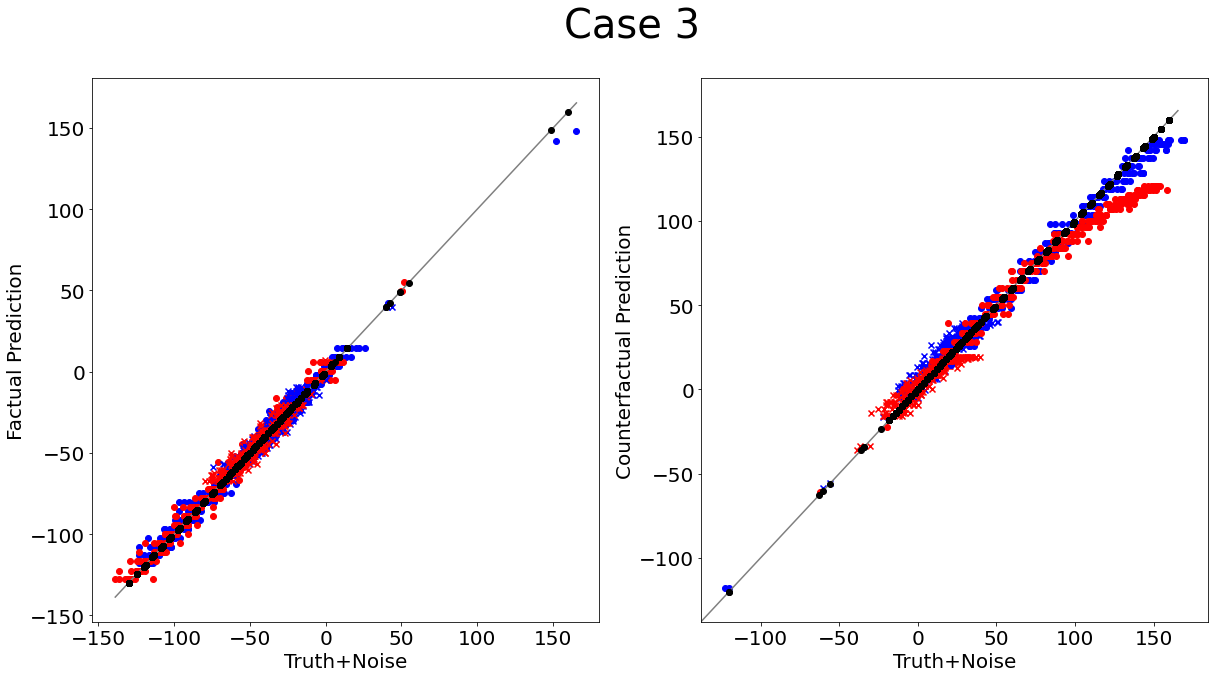

In [24]:
if doDraw:
    yType = str(caseType)
    drawTruthNoise(trainCaseData, yTrainPred, yTrainPredCF, yType, titleAppend=None)

In [19]:
print("{:05f}/{:05f}".format(RMSE(yTrainPred[:, 0], trainCaseData.data['y{}'.format(caseType)]), RMSE(trainCaseData.data['yo{}'.format(caseType)], trainCaseData.data['y{}'.format(caseType)])))
print("{:05f}/{:05f}".format(RMSE(yTrainPredCF[:, 0], trainCaseData.data['y{}CF'.format(caseType)]), RMSE(trainCaseData.data['yo{}CF'.format(caseType)], trainCaseData.data['y{}CF'.format(caseType)])))

5.010588/4.862048
8.568913/4.995497


In [20]:
#del model

In [21]:
PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
t.save(model.state_dict(), PATH)

In [22]:
the_model = NeuralNetwork()
the_model.load_state_dict(t.load(PATH))

<All keys matched successfully>